In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Import Library**

In [2]:
!pip install category_encoders
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import joblib
import pickle
import category_encoders as ce

from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
from sklearn.metrics import confusion_matrix

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 86.6 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.0
    Uninstalling scikit-learn-1.6.0:
      Successfully uninstalled scikit-learn-1.6.0


**Load Data**

In [3]:
data = pd.read_csv('/content/drive/MyDrive/Skripsi/Dataset/Dataset PMB UNISS 2020-2023.csv')
data.head()

,id_pendaftaran,tahun_pendaftaran,jenis_kelamin,usia,kota_asal,agama,asal_sekolah,pekerjaan,penghasilan,pilihan_prodi,program_kelas,gelombang,status
0,0001/12/2019,2020,Laki-laki,26.0,Batang,Islam,SMK,Petani,"Rp. 2,000,000 - Rp. 2,999,999",S1 - Teknik Sipil,Reguler Malam,1.0,Ya
1,0002/12/2019,2020,Laki-laki,19.0,Pekalongan,Kristen,SMK,Petani,"Rp. 3,000,000 - Rp. 3,999,999",S1 - Teknik Sipil,Reguler Malam,1.0,Ya
2,0003/01/2020,2020,Perempuan,23.0,Batang,Islam,SMA,Buruh,"Rp. 1,000,000 - Rp. 1,999,999",S1 - Manajemen,Reguler Pagi,1.0,Ya
3,0004/01/2020,2020,Laki-laki,25.0,Batang,Islam,SMA,Karyawan,"Rp. 3,000,000 - Rp. 3,999,999",S1 - Manajemen,Reguler Malam,1.0,Tidak
4,0005/01/2020,2020,Laki-laki,25.0,Batang,Islam,MA,Pedagang,"Rp. 1,000,000 - Rp. 1,999,999",S1 - Ilmu Pemerintahan,Reguler Malam,1.0,Tidak


**Data Preprocessing**

**1. Data Cleaning**

In [4]:
#melihat nilai kosong pada data
data.isnull().sum()

,0
id_pendaftaran,0
tahun_pendaftaran,0
jenis_kelamin,7
usia,7
kota_asal,7
agama,7
asal_sekolah,7
pekerjaan,8
penghasilan,8
pilihan_prodi,7


1. Menghapus Data Kosong

In [5]:
data = data.dropna()
data.isnull().sum()

,0
id_pendaftaran,0
tahun_pendaftaran,0
jenis_kelamin,0
usia,0
kota_asal,0
agama,0
asal_sekolah,0
pekerjaan,0
penghasilan,0
pilihan_prodi,0


2. Menghapus Fitur Yang Tidak Diperlukan

In [6]:
# menghapus kolom id_pendaftaran
data.drop(columns=['id_pendaftaran'], inplace=True)

3. Membersihkan Data

In [7]:
def preprocess_data(df):
    # Ubah teks menjadi huruf kecil dan hapus karakter yang tidak diinginkan
    for column in ['jenis_kelamin', 'kota_asal', 'agama', 'asal_sekolah', 'pekerjaan', 'pilihan_prodi', 'program_kelas', 'status']:
        df[column] = df[column].str.strip().str.lower()
        df[column] = df[column].apply(lambda x: re.sub(r'[^a-z\s0-9,-]', '', x))

    # Hapus prefiks pada 'pilihan_prodi' dan bersihkan teks.
    def clean_program_study(s):
        if pd.isnull(s):
            return ''
        s = s.replace('s1 - ', '').strip()
        return s
    df['pilihan_prodi'] = df['pilihan_prodi'].apply(clean_program_study)

    # Format fitur penghasilan
    def extract_mid_range(s):
        if pd.isnull(s) or s == '':
            return None
        s = s.replace('Rp. ', '').replace('rp ', '').replace(',', '').replace('.', '').strip()

        if '<=' in s:
            try:
                return float(s.replace('<=', '').strip())
            except ValueError:
                return None
        elif '>=' in s:
            try:
                return float(s.replace('>=', '').strip())
            except ValueError:
                return None

        if '-' in s:
            parts = s.split('-')
            try:
                lower_bound = float(parts[0])
                upper_bound = float(parts[1])
                return (lower_bound + upper_bound) / 2
            except ValueError:
                return None
        else:
            try:
                return float(s)
            except ValueError:
                return None

    df['penghasilan'] = df['penghasilan'].apply(extract_mid_range)
    return df
data = preprocess_data(data)

# Mengubah tipe data kolom float menjadi int
data['usia'] = data['usia'].astype(int)
data['gelombang'] = data['gelombang'].astype(int)

In [8]:
data['status'].value_counts()

,count
status,
ya,1121
tidak,229


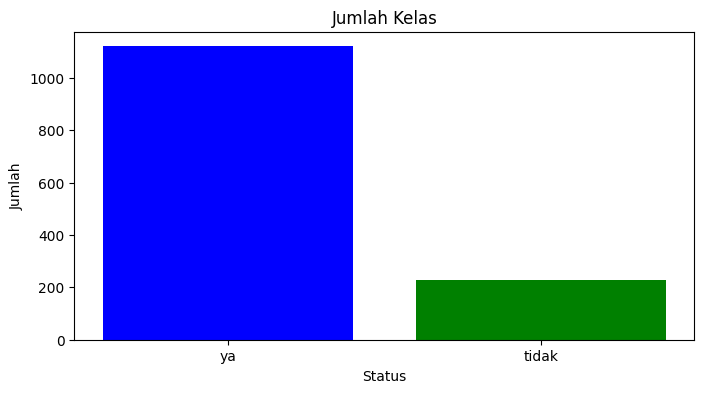

In [9]:
# Visualisasi Jumlah Kelas dengan Bar Chart
status_counts = data['status'].value_counts()
plt.figure(figsize=(8, 4))
plt.bar(status_counts.index, status_counts.values, color=['blue', 'green'])
plt.title('Jumlah Kelas')
plt.xlabel('Status')
plt.ylabel('Jumlah')
plt.show()

**2. Data Transformation**

In [10]:
# Ubah label 'status' menjadi numerik
encoder_label = ce.OrdinalEncoder(cols=['status'])
data = encoder_label.fit_transform(data)

In [11]:
encoder = ce.OrdinalEncoder(cols=['tahun_pendaftaran','jenis_kelamin', 'kota_asal', 'agama',
             'asal_sekolah', 'pekerjaan', 'penghasilan','pilihan_prodi', 'program_kelas'])

data = encoder.fit_transform(data)

In [12]:
data.head()

,tahun_pendaftaran,jenis_kelamin,usia,kota_asal,agama,asal_sekolah,pekerjaan,penghasilan,pilihan_prodi,program_kelas,gelombang,status
0,1,1,26,1,1,1,1,1,1,1,1,1
1,1,1,19,2,2,1,1,2,1,1,1,1
2,1,2,23,1,1,2,2,3,2,2,1,1
3,1,1,25,1,1,2,3,2,2,1,1,2
4,1,1,25,1,1,3,4,3,3,1,1,2


In [ ]:
data.to_excel('/content/drive/MyDrive/Skripsi/Dataset/data_transformed.xlsx', index=False)

In [ ]:
# Save encoder
joblib.dump(encoder, '/content/drive/MyDrive/Skripsi/Model/encoder.pkl')

Inisialisasi Fitur dan Label

In [13]:
X = data.drop('status', axis=1)
y = data['status']

**Data Balancing (SMOTE)**

In [14]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

print("Distribusi kelas sebelum SMOTE:", Counter(y))
print("Distribusi kelas setelah SMOTE:", Counter(y_smote))

Distribusi kelas sebelum SMOTE: Counter({1: 1121, 2: 229})
Distribusi kelas setelah SMOTE: Counter({1: 1121, 2: 1121})


Visualisasi Kelas Sebelum dan Sesudah SMOTE

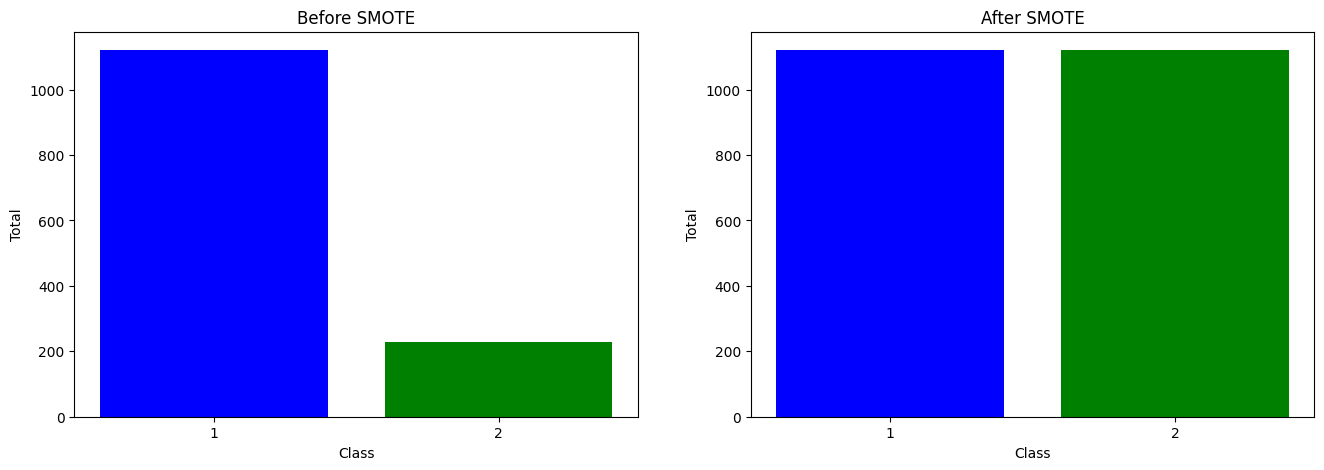

In [15]:
# Data sebelum SMOTE
before_smote = Counter(y)
classes_before = list(before_smote.keys())
counts_before = list(before_smote.values())

# Data setelah SMOTE
after_smote = Counter(y_smote)
classes_after = list(after_smote.keys())
counts_after = list(after_smote.values())

# Membuat bar chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Bar chart sebelum SMOTE
ax1.bar(classes_before, counts_before, color=['blue', 'green'])
ax1.set_xticks(classes_before)
ax1.set_xlabel('Class')
ax1.set_ylabel('Total')
ax1.set_title('Before SMOTE')

# Bar chart setelah SMOTE
ax2.bar(classes_after, counts_after, color=['blue', 'green'])
ax2.set_xticks(classes_after)
ax2.set_xlabel('Class')
ax2.set_ylabel('Total')
ax2.set_title('After SMOTE')

plt.show()

In [ ]:
# Gabungkan X_smote dan y_smote menjadi satu DataFrame
data_smote = pd.concat([X_smote, y_smote], axis=1)

**Feature Selection (Chi Square)**

In [ ]:
k_best = SelectKBest(score_func=chi2, k='all')
fit = k_best.fit(X_smote, y_smote)
feature_scores = pd.DataFrame({'Feature': X.columns, 'Score': fit.scores_, 'p-value': fit.pvalues_})

In [ ]:
# Urutkan Dataset Berdasarkan Urutan Nilai
feature_scores = feature_scores.sort_values(by='Score', ascending=False)

# Menambahkan Kolom ranking
feature_scores['Rank'] = range(1, len(feature_scores) + 1)

# Memformat nilai p-value
feature_scores['p-value'] = feature_scores['p-value'].apply(lambda x: '{:.6f}'.format(x))

print("Chi-square scores:")
print(feature_scores)

Chi-square scores:
              Feature       Score   p-value  Rank
3           kota_asal  190.789685  0.000000     1
7         penghasilan  171.349868  0.000000     2
2                usia   79.622984  0.000000     3
0   tahun_pendaftaran   74.345852  0.000000     4
6           pekerjaan   73.703671  0.000000     5
8       pilihan_prodi   62.896183  0.000000     6
9       program_kelas   33.835886  0.000000     7
5        asal_sekolah   18.334402  0.000019     8
10          gelombang    5.294488  0.021393     9
1       jenis_kelamin    0.461932  0.496722    10
4               agama    0.001783  0.966323    11


In [ ]:
X_best = data_smote[['kota_asal', 'penghasilan', 'usia', 'tahun_pendaftaran','pekerjaan', 'pilihan_prodi', 'program_kelas', 'asal_sekolah', 'gelombang']]
y_best = data_smote['status']

**Pembagian Data Training dan Data Testing**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_best, y_best, test_size = 0.2, random_state = 42)
X_train.shape, X_test.shape

((1793, 9), (449, 9))

**Modelling Algoritma Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

#Membuat Model Random Forest
rf = RandomForestClassifier(random_state=42)

#Melatih Model Random Forest
rf.fit(X_train, y_train)

#Melakukan prediksi label dengan data testing
y_pred = rf.predict(X_test)

In [ ]:
# Save model
joblib.dump(rf, '/content/drive/MyDrive/Skripsi/Model/model_random_forest.pkl')

**Evaluasi Model (Confusion Matrix)**

In [ ]:
cm = confusion_matrix(y_test, y_pred)

print('Confusion matrix\n\n', cm)
print('\n Accuracy : {0:.2f}%'. format(accuracy_score(y_test, y_pred)* 100))

Confusion matrix

 [[221  20]
 [  8 200]]

 Accuracy : 93.76%


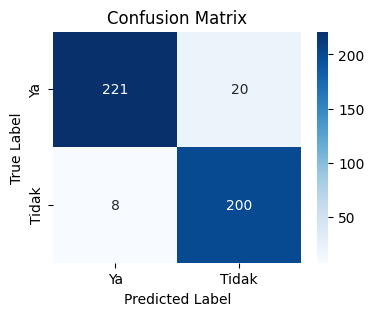

In [ ]:
#Visualisasi Confusion Matrix
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ya', 'Tidak'], yticklabels=['Ya', 'Tidak'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
#Melihat Hasil classification Report
report = classification_report(y_test, y_pred, target_names=['Ya','Tidak'])
print(report)

              precision    recall  f1-score   support

          Ya       0.97      0.92      0.94       241
       Tidak       0.91      0.96      0.93       208

    accuracy                           0.94       449
   macro avg       0.94      0.94      0.94       449
weighted avg       0.94      0.94      0.94       449

